Control type: xyz_pos
Simulated 18.00s in 5.319046s.
MovieWriter imagemagick unavailable; using Pillow instead.


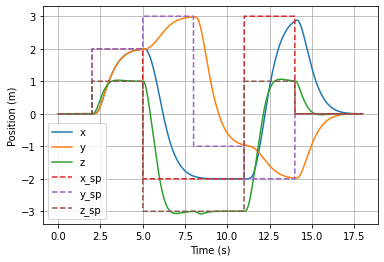

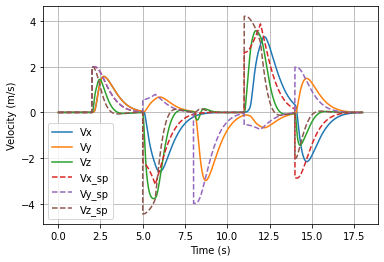

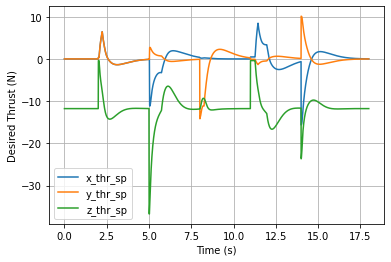

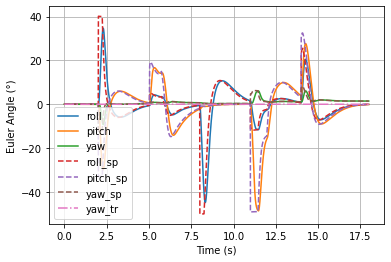

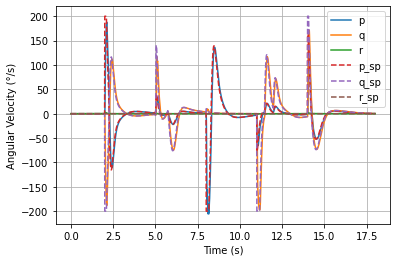

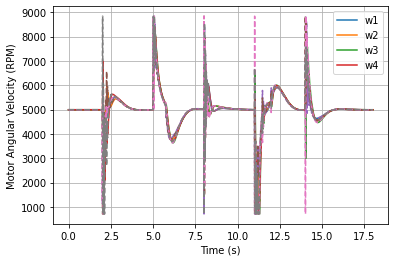

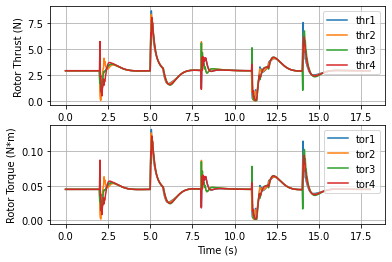

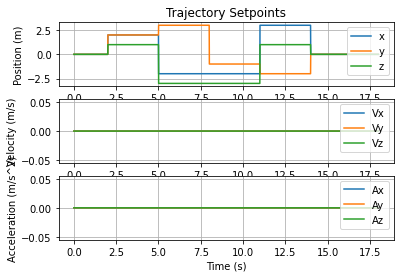

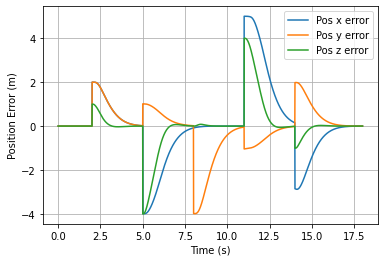

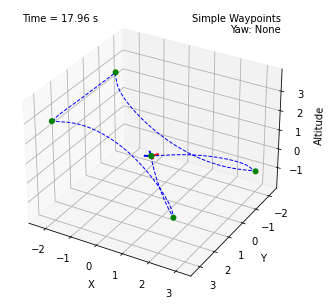

In [1]:
# -*- coding: utf-8 -*-
"""
author: John Bass
email: john.bobzwik@gmail.com
license: MIT
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
import matplotlib.pyplot as plt
import time
import cProfile

from trajectory import Trajectory
from ctrl import Control
from quadFiles.quad import Quadcopter
from utils.windModel import Wind
import utils
import config


def quad_sim(t, Ts, quad, ctrl, wind, traj):

    # Dynamics (using last timestep's commands)
    # ---------------------------
    quad.update(t, Ts, ctrl.w_cmd, wind)
    t += Ts

    # Trajectory for Desired States
    # ---------------------------
    sDes = traj.desiredState(t, Ts, quad)

    # Generate Commands (for next iteration)
    # ---------------------------
    ctrl.controller(traj, quad, sDes, Ts)

    return t


def init_data(quad, traj, ctrl, numTimeStep):
    t_all = np.zeros(numTimeStep)
    s_all = np.zeros([numTimeStep, len(quad.state)])
    pos_all = np.zeros([numTimeStep, len(quad.pos)])
    vel_all = np.zeros([numTimeStep, len(quad.vel)])
    quat_all = np.zeros([numTimeStep, len(quad.quat)])
    omega_all = np.zeros([numTimeStep, len(quad.omega)])
    euler_all = np.zeros([numTimeStep, len(quad.euler)])
    sDes_traj_all = np.zeros([numTimeStep, len(traj.sDes)])
    sDes_calc_all = np.zeros([numTimeStep, len(ctrl.sDesCalc)])
    w_cmd_all = np.zeros([numTimeStep, len(ctrl.w_cmd)])
    wMotor_all = np.zeros([numTimeStep, len(quad.wMotor)])
    thr_all = np.zeros([numTimeStep, len(quad.thr)])
    tor_all = np.zeros([numTimeStep, len(quad.tor)])
    return (
        t_all,
        s_all,
        pos_all,
        vel_all,
        quat_all,
        omega_all,
        euler_all,
        sDes_traj_all,
        sDes_calc_all,
        w_cmd_all,
        wMotor_all,
        thr_all,
        tor_all,
    )


def main():
    start_time = time.time()

    # Simulation Setup
    # ---------------------------
    Ti = 0
    Ts = 0.005
    Tf = 18
    ifsave = 1

    # Choose trajectory settings
    # ---------------------------
    ctrlOptions = ["xyz_pos", "xy_vel_z_pos", "xyz_vel"]
    trajSelect = np.zeros(3)

    # Select Control Type             (0: xyz_pos,                  1: xy_vel_z_pos,            2: xyz_vel)
    ctrlType = ctrlOptions[0]
    # Select Position Trajectory Type (0: hover,                    1: pos_waypoint_timed,      2: pos_waypoint_interp,
    #                                  3: minimum velocity          4: minimum accel,           5: minimum jerk,           6: minimum snap
    #                                  7: minimum accel_stop        8: minimum jerk_stop        9: minimum snap_stop
    #                                 10: minimum jerk_full_stop   11: minimum snap_full_stop
    #                                 12: pos_waypoint_arrived
    trajSelect[0] = 1  # (changed): was 6
    # Select Yaw Trajectory Type      (0: none                      1: yaw_waypoint_timed,      2: yaw_waypoint_interp     3: follow          4: zero)
    trajSelect[1] = 0  # (changed): was 6
    # Select if waypoint time is used, or if average speed is used to calculate waypoint time   (0: waypoint time,   1: average speed)
    trajSelect[2] = 0
    print("Control type: {}".format(ctrlType))

    # Initialize Quadcopter, Controller, Wind, Result Matrixes
    # ---------------------------
    quad = Quadcopter(Ti)
    traj = Trajectory(quad, ctrlType, trajSelect)
    ctrl = Control(quad, traj.yawType)
    wind = Wind("None", 2.0, 90, -15)

    # Trajectory for First Desired States
    # ---------------------------
    sDes = traj.desiredState(0, Ts, quad)  # np.zeros(19)

    # Generate First Commands
    # ---------------------------
    ctrl.controller(traj, quad, sDes, Ts)

    # Initialize Result Matrixes
    # ---------------------------
    numTimeStep = int(Tf / Ts + 1)
    (
        t_all,
        s_all,
        pos_all,
        vel_all,
        quat_all,
        omega_all,
        euler_all,
        sDes_traj_all,
        sDes_calc_all,
        w_cmd_all,
        wMotor_all,
        thr_all,
        tor_all,
    ) = init_data(quad, traj, ctrl, numTimeStep)

    t_all[0] = Ti
    s_all[0, :] = quad.state
    pos_all[0, :] = quad.pos
    vel_all[0, :] = quad.vel
    quat_all[0, :] = quad.quat
    omega_all[0, :] = quad.omega
    euler_all[0, :] = quad.euler
    sDes_traj_all[0, :] = traj.sDes
    sDes_calc_all[0, :] = ctrl.sDesCalc
    w_cmd_all[0, :] = ctrl.w_cmd
    wMotor_all[0, :] = quad.wMotor
    thr_all[0, :] = quad.thr
    tor_all[0, :] = quad.tor

    # Run Simulation
    # ---------------------------
    t = Ti
    i = 1
    while round(t, 3) < Tf:

        t = quad_sim(t, Ts, quad, ctrl, wind, traj)

        # print("{:.3f}".format(t))
        t_all[i] = t
        s_all[i, :] = quad.state
        pos_all[i, :] = quad.pos
        vel_all[i, :] = quad.vel
        quat_all[i, :] = quad.quat
        omega_all[i, :] = quad.omega
        euler_all[i, :] = quad.euler
        sDes_traj_all[i, :] = traj.sDes
        sDes_calc_all[i, :] = ctrl.sDesCalc
        w_cmd_all[i, :] = ctrl.w_cmd
        wMotor_all[i, :] = quad.wMotor
        thr_all[i, :] = quad.thr
        tor_all[i, :] = quad.tor

        i += 1

    end_time = time.time()
    print("Simulated {:.2f}s in {:.6f}s.".format(t, end_time - start_time))

    # View Results
    # ---------------------------

    # utils.fullprint(sDes_traj_all[:,3:6])
    utils.makeFigures(
        quad.params,
        t_all,
        pos_all,
        vel_all,
        quat_all,
        omega_all,
        euler_all,
        w_cmd_all,
        wMotor_all,
        thr_all,
        tor_all,
        sDes_traj_all,
        sDes_calc_all,
    )
    ani = utils.sameAxisAnimation(
        t_all, traj.wps, pos_all, quat_all, sDes_traj_all, Ts, quad.params, traj.xyzType, traj.yawType, ifsave
    )
    plt.show()


if __name__ == "__main__":
    if config.orient == "NED" or config.orient == "ENU":
        main()
        # cProfile.run('main()')
    else:
        raise Exception("{} is not a valid orientation. Verify config.py file.".format(config.orient))